In [ ]:
# Some installations upfront
!git clone https://github.com/automl/PFNs.git
!cd PFNs; git pull; pip install -e .; cd -

fatal: destination path 'PFNs' already exists and is not an empty directory.
Obtaining file:///content/PFNs
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pfns (pyproject.toml) ... done
  Created wheel for pfns: filename=pfns-0.1.5-py3-none-any.whl size=2065 sha256=24a7fc36a043963ae78f872a93711420d635570c0a964cb010de6d770ed50ae4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzrdv8g1/wheels/41/e8/5e/8042c7868a7305823e73e1c689f4f056028828e1bc8bfda37c
Successfully built pfns
  Attempting uninstall: pfns
    Found existing installation: pfns 0.1.5
    Uninstalling pfns-0.1.5:
      Successfully uninstalled pfns-0.1.5
/content


In [ ]:
# if this import fails, please restart the notebook:
# 1. click on "Runtime"
# 2. click "Restart runtime"
try:
    import pfns
except ImportError:
    raise ImportError("Please restart runtime by i) clicking on \'Runtime\' and then ii) clicking \'Restart runtime\'")

In [ ]:
from pfns import utils
device = utils.default_device
print('using', device, 'to use GPU, enable it under Runtime')

import matplotlib.pyplot as plt

import torch
from torch import nn

from pfns.train import train
from pfns.priors.utils import get_batch_to_dataloader
from pfns import encoders
from pfns import utils
from pfns import bar_distribution
from pfns.priors import Batch

In [ ]:
# Let's fix some global settings

hps = None
num_features = 1
max_dataset_size = 20

def train_a_pfn(get_batch_function, epochs=20, max_dataset_size=max_dataset_size, num_features=num_features,
                hps=hps, lr=.001, batch_size=8, **kwargs
               ):

    # define a bar distribution (riemann distribution) criterion with 100 bars
    ys = get_batch_function(100000,20,num_features, hyperparameters=hps).target_y.to(device)
    # we define our bar distribution adaptively with respect to the above sample of target ys from our prior
    criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=100, ys=ys))

    # now train
    train_result = train(# the prior is the key. It defines what we train on.
                         get_batch_function, criterion=criterion,
                         # define the transformer size
                         emsize=256, nhead=4, nhid=512, nlayers=4,
                         # how to encode the x and y inputs to the transformer
                         encoder_generator=encoders.get_normalized_uniform_encoder(encoders.Linear),
                         y_encoder_generator=encoders.Linear,
                         # these are given to the prior, which needs to know how many features we have etc
                         extra_prior_kwargs_dict=\
                            {'num_features': num_features, 'fuse_x_y': False, 'hyperparameters': hps},
                         # change the number of epochs to put more compute into a training
                         # an epoch length is defined by `steps_per_epoch`
                         # the below means we do 10 epochs, with 100 batches per epoch and 4 datasets per batch
                         # that means we look at 10*100*4 = 4000 datasets, typically we train on milllions of datasets.
                         epochs=epochs, warmup_epochs=epochs//4, steps_per_epoch=100,batch_size=batch_size,
                         # the lr is what you want to tune! usually something in [.00005,.0001,.0003,.001] works best
                         # the lr interacts heavily with `batch_size` (smaller `batch_size` -> smaller best `lr`)
                         lr=lr,
                         # seq_len defines the size of your datasets (including the test set)
                         seq_len=max_dataset_size,
                         # single_eval_pos_gen defines where to cut off between train and test set
                         # a function that (randomly) returns lengths of the training set
                         # the below definition, will just choose the size uniformly at random up to `max_dataset_size`
                         single_eval_pos_gen=utils.get_uniform_single_eval_pos_sampler(max_dataset_size),
                         **kwargs
    )
    return train_result

The next two functions describe the data we sample. First we define a function that can generate batches of lines, sine curves and sloped sine curves (`get_batch_for_sine_ridge_regression`).

Then we define a function (`get_batch_sine_or_line`) that samples batches of only sines or sloped lines (never sloped sines) from this function and hands them on.

Our transformer is trained to predict some hold out `y` for each dataset sampled from these functions.

In [ ]:
def get_batch_for_sine_ridge_regression(batch_size=10,seq_len=100,num_features=1,
                                   hyperparameters=None, **kwargs):
    if hyperparameters is None:
        hyperparameters = {'a': 0.01, 'b': 1.0, 's': .3}

    if hyperparameters['b']:
        ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['b']).sample((batch_size,))
    else:
        ws = torch.zeros(batch_size, num_features+1)

    if (b_zero := hyperparameters.get('b_zero')) is not None:
        ws[:, -1] = torch.randn(batch_size) * b_zero

    xs = torch.rand(batch_size, seq_len, num_features)
    noiseless_ys = torch.einsum('nmf, nf -> nm',
                     torch.cat([xs,torch.ones(batch_size, seq_len,1)],2),
                     ws
                    )
    if hyperparameters['a']:
        ys = torch.distributions.Normal(
            noiseless_ys,
            hyperparameters['a']
        ).sample()
    else:
        ys = noiseless_ys

    ## the new part

    ys += torch.sin(xs[...,0]*20) * hyperparameters['s']

    ## end new part

    # get_batch functions return two different ys, let's come back to this later, though.
    return Batch(x=xs.transpose(0,1), y=ys.transpose(0,1), target_y=ys.transpose(0,1))



In [ ]:
def get_batch_sine_or_line(batch_size=10,seq_len=100,num_features=1,
                                   hyperparameters={}, device='cpu', **kwargs):
    sine_mask = torch.rand(batch_size) < .5
    if sine_mask.any():
        result_sine = get_batch_for_sine_ridge_regression(sine_mask.sum(), seq_len, num_features, hyperparameters=hyperparameters.get('sine', {'a': 0.05, 'b': 0.0, 's': .3, 'b_zero': 1.0}))
    if not sine_mask.all():
        result_line = get_batch_for_sine_ridge_regression((~sine_mask).sum(), seq_len, num_features, hyperparameters=hyperparameters.get('line', {'a': 0.05, 'b': 1.0, 's': 0.}))

    x = torch.empty(seq_len, batch_size, num_features)
    x[:, sine_mask] = result_sine.x
    x[:, ~sine_mask] = result_line.x

    y = torch.empty(seq_len, batch_size)
    y[:, sine_mask] = result_sine.y
    y[:, ~sine_mask] = result_line.y

    return Batch(x=x.to(device), y=y.to(device), target_y=y.clone().to(device))

Let's sample from this prior...

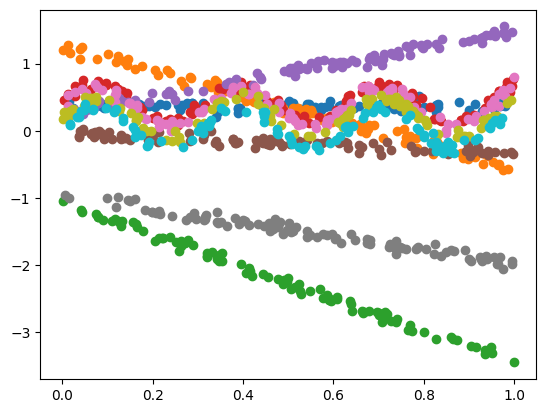

In [ ]:
batch = get_batch_sine_or_line()
for dataset_index in range(batch.x.shape[1]):
    plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.y[:,dataset_index].numpy())

#### Funky curves, let's train our transfomer!!!

In [ ]:
train_results_sine_or_line = train_a_pfn(get_batch_sine_or_line, lr=.001, batch_size=128, epochs=100, style_encoder_generator=encoders.get_normalized_uniform_encoder(encoders.Linear))
trained_model_sine_or_line = train_results_sine_or_line[2]

Using 2000000 y evals to estimate 100 buckets. Cut off the last 0 ys.
Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 128, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7b203a2068c0>, 'seq_len_maximum': 20, 'device': 'cuda:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': {'use_style': False}}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 100)  and nout 100
Using a Transformer with 2.29 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.36s | mean loss  1.57 | pos losses  1.46, 1.55, 1.58, 1.60, 1.58, 1.60, 1.50, 1.60, 1.53, 1.48, 1.59, 1.57, 1.59, 1.57, 1.58, 1.59, 1.53, 1.57, 1.56, 1.61, lr 0.0 data time  0.01 step time  0.06 forward time  0.03 nan share  0.00 ignore share (for classification tasks) 0

In [ ]:
batch = get_batch_for_sine_ridge_regression(seq_len=300, hyperparameters={'a': 0., 'b': .5, 's': .3, 'b_zero': 0.})

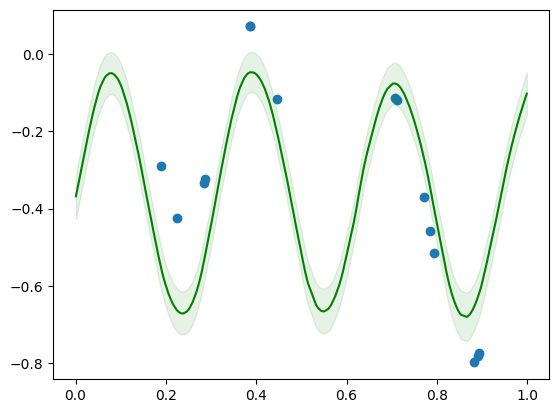

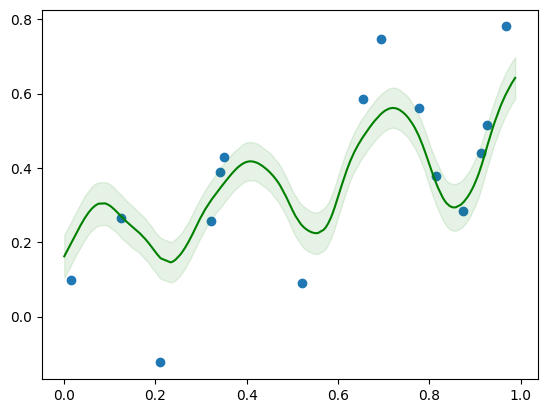

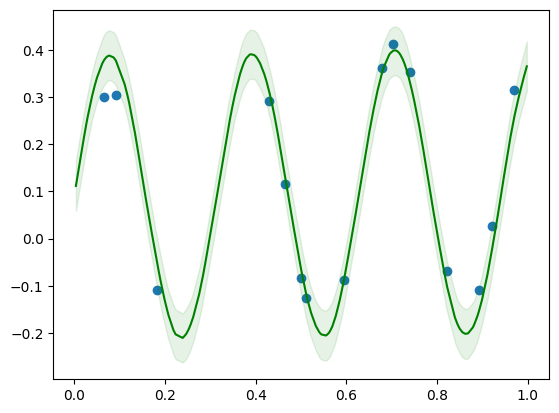

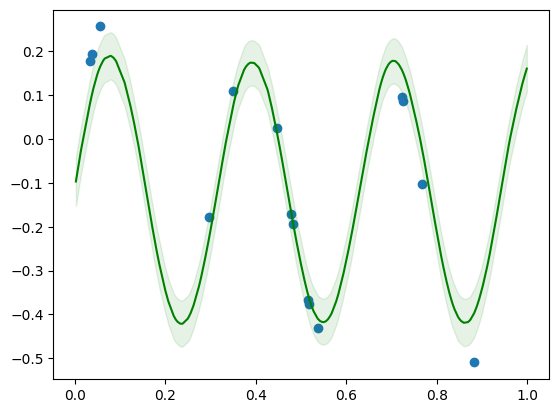

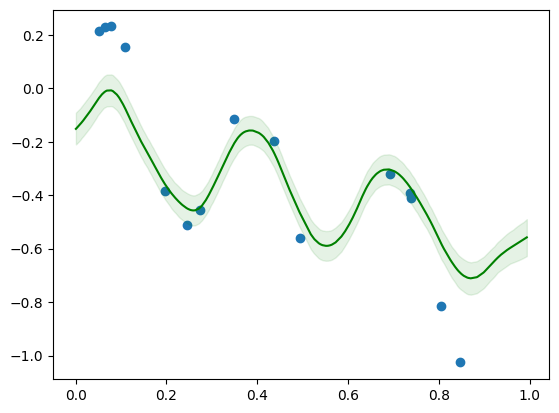

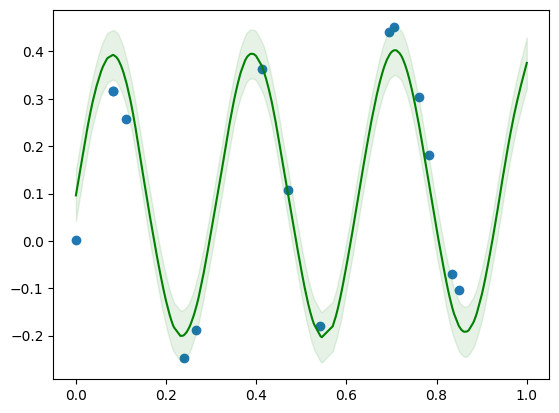

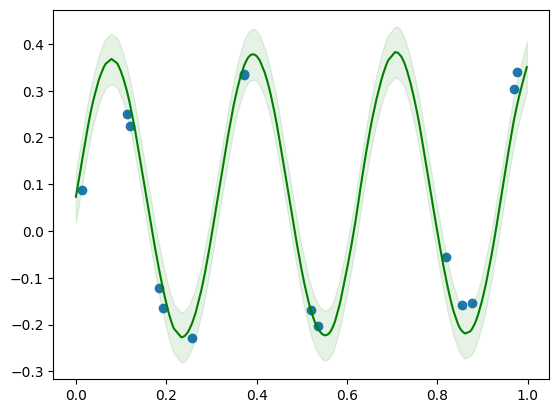

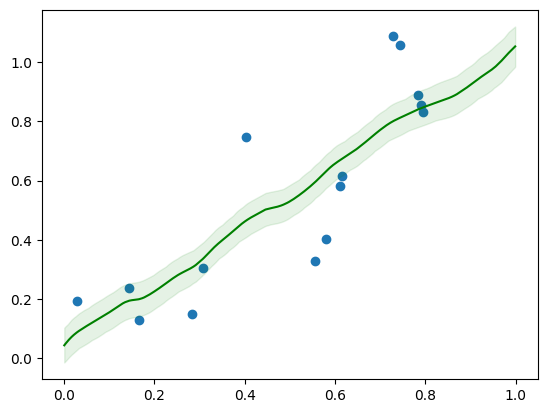

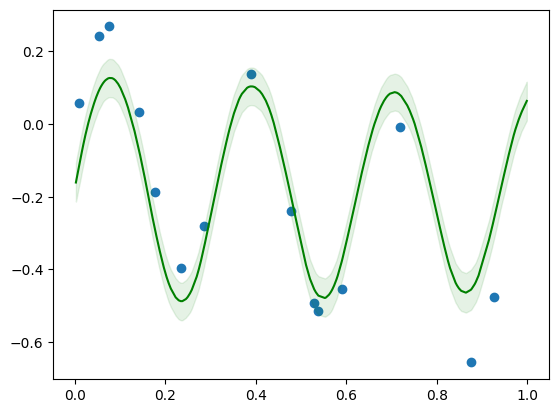

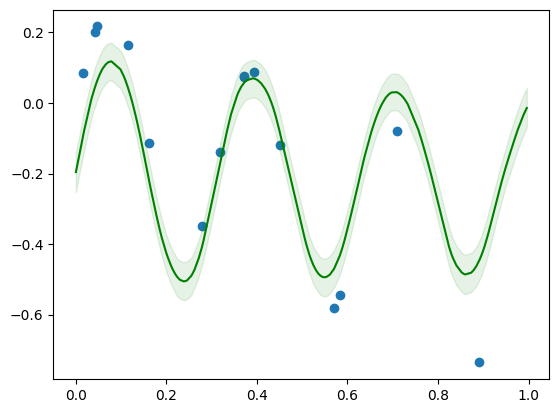

In [ ]:
# our model wants the seq dimension first, remember that!

for batch_index in range(batch.x.shape[1]):
    num_training_points = 15

    train_x = batch.x[:num_training_points, batch_index]
    train_y = batch.y[:num_training_points, batch_index]
    test_x = batch.x[:, batch_index]

    with torch.no_grad():
        # we add our batch dimension, as our transformer always expects that
        logits = trained_model_sine_or_line(train_x[:,None], train_y[:,None], test_x[:,None],)# style=torch.tensor([[0.5]]))

    # the model has the criterion still attached (it is the same though, as our criterion above)
    # the criterion has a lot of handy function to use these logits
    pred_means = trained_model_sine_or_line.criterion.mean(logits)
    pred_confs = trained_model_sine_or_line.criterion.quantile(logits)


    plt.scatter(train_x[...,0],train_y)
    order_test_x = test_x[...,0].argsort()
    plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
    plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')
    plt.show()

Actually, above the noise might play a big role, but it even seems to work without the noise. Which is interesting, as here the functions truly are not supported by the distribution of the training functions.

The other thing, I did above, was to allow the sine curves to appear at different heights.

Below, I remove both of these things and we can see that the curves become more ugly, but we can still see the generalization.


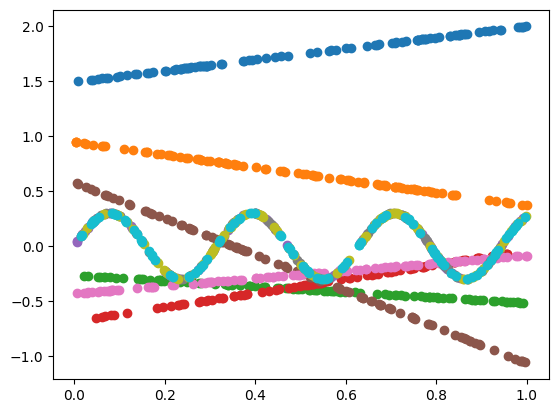

In [ ]:
batch = get_batch_sine_or_line(hyperparameters={'sine': {'a': 0.0, 'b': 0.0, 's': .3, }, 'line': {'a': 0.0, 'b': 1.0, 's': 0.}})
for dataset_index in range(batch.x.shape[1]):
    plt.scatter(batch.x[:,dataset_index,0].numpy(), batch.y[:,dataset_index].numpy())

In [ ]:
train_results_sine_or_line_no_noise = train_a_pfn(get_batch_sine_or_line, lr=.001, batch_size=128, epochs=200, style_encoder_generator=encoders.get_normalized_uniform_encoder(encoders.Linear),
                                         hps={'sine': {'a': 0.0, 'b': 0.0, 's': .3, }, 'line': {'a': 0.0, 'b': 1.0, 's': 0.}} #'b_zero': 1.0
                                         )
trained_model_sine_or_line_no_noise = train_results_sine_or_line_no_noise[2]

Using 2000000 y evals to estimate 100 buckets. Cut off the last 0 ys.
Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 128, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7b1fe54ecaf0>, 'seq_len_maximum': 20, 'device': 'cuda:0', 'num_features': 1, 'fuse_x_y': False, 'hyperparameters': {'sine': {'a': 0.0, 'b': 0.0, 's': 0.3}, 'line': {'a': 0.0, 'b': 1.0, 's': 0.0}}}, 'num_features': 1, 'epoch_count': 0}
Style definition of first 3 examples: None
Initialized decoder for standard with (None, 100)  and nout 100
Using a Transformer with 2.29 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.72s | mean loss  0.92 | pos losses  0.91, 0.97, 0.96, 0.93, 0.90, 0.91, 1.06, 0.89, 0.82, 0.91, 1.00, 0.96, 0.88, 0.92, 1.00, 0.89, 0.90, 0.82, 0.80, 0.96, lr 0.0 data time  0.00 step time  0.02 forward time  0.

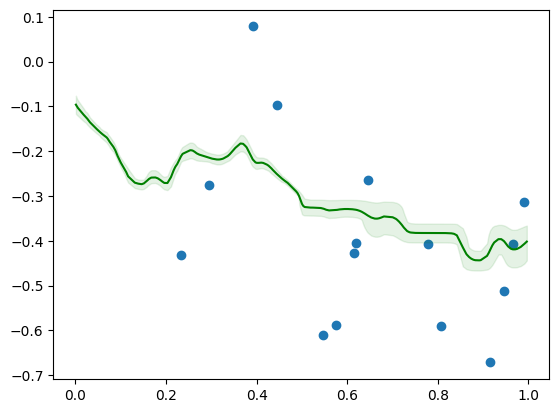

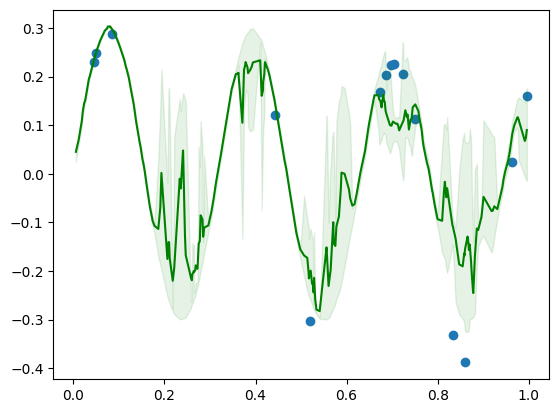

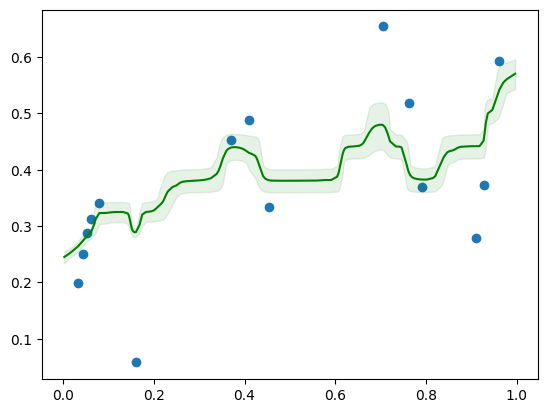

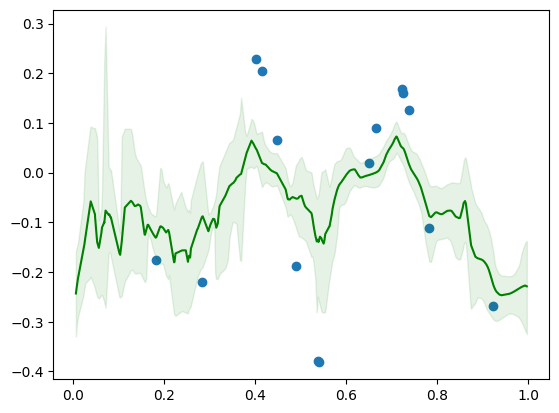

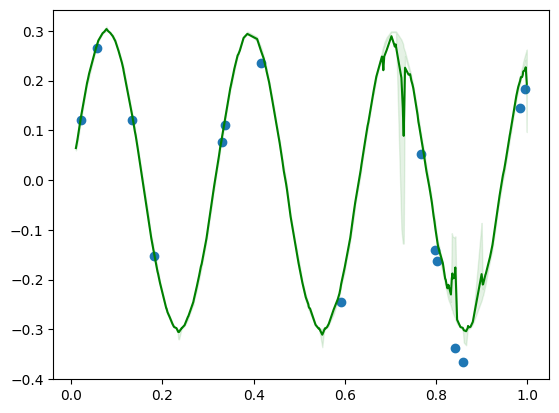

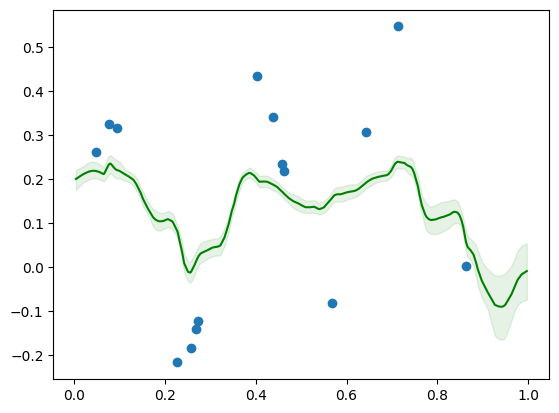

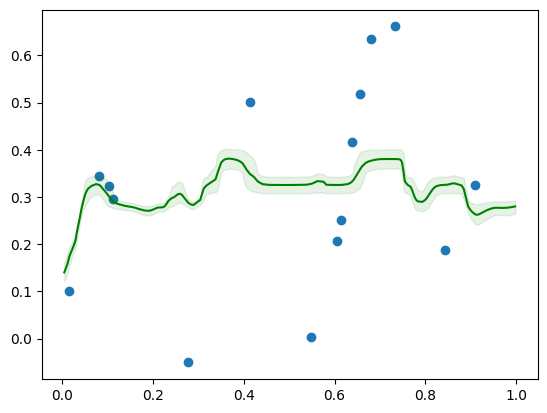

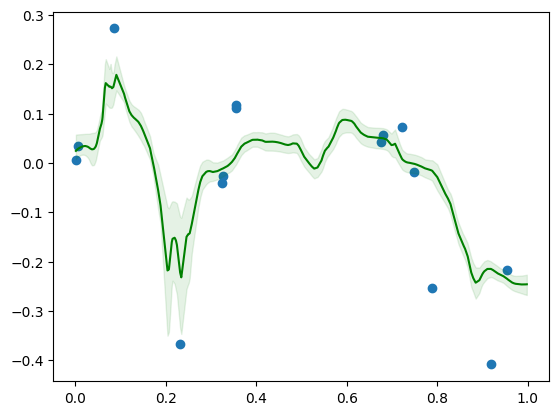

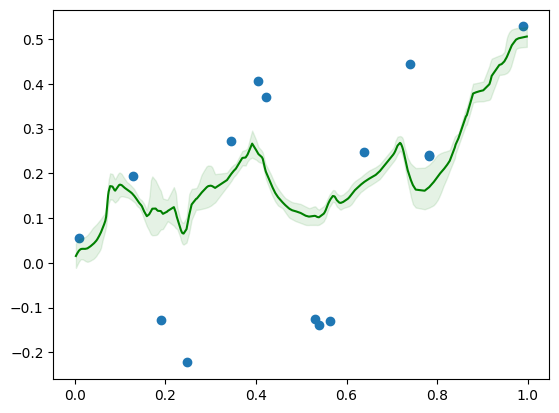

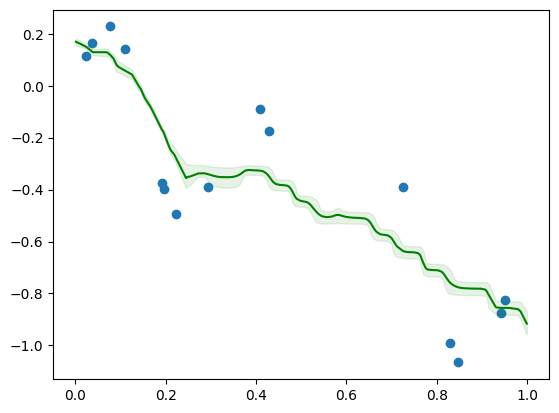

In [ ]:
batch = get_batch_for_sine_ridge_regression(seq_len=300, hyperparameters={'a': 0., 'b': .5, 's': .3, 'b_zero': 0.})

# our model wants the seq dimension first, remember that!
for batch_index in range(batch.x.shape[1]):
    num_training_points = 15

    train_x = batch.x[:num_training_points, batch_index]
    train_y = batch.y[:num_training_points, batch_index]
    test_x = batch.x[:, batch_index]

    with torch.no_grad():
        # we add our batch dimension, as our transformer always expects that
        logits = trained_model_sine_or_line_no_noise(train_x[:,None], train_y[:,None], test_x[:,None],)# style=torch.tensor([[0.5]]))

    # the model has the criterion still attached (it is the same though, as our criterion above)
    # the criterion has a lot of handy function to use these logits
    pred_means = trained_model_sine_or_line_no_noise.criterion.mean(logits)
    pred_confs = trained_model_sine_or_line_no_noise.criterion.quantile(logits)


    plt.scatter(train_x[...,0],train_y)
    order_test_x = test_x[...,0].argsort()
    plt.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
    plt.fill_between(test_x[order_test_x, ..., 0], pred_confs[...,0 , 0][order_test_x], pred_confs[...,0 ,1][order_test_x], alpha=.1, color='green')
    plt.show()